### This notebook iterates through a site and scrapes each page for the CPI value for a set time period

In [1]:
## Ran on python 3.9.18
from splinter import Browser # 0.19.0
from bs4 import BeautifulSoup # 4.11.1
import numpy as np # 1.26.0
import pandas as pd # 2.1.1
import matplotlib.pyplot as plt # 3.8.0
## These last imports are important to find appropriate driver to run on chrome version
# the version of selenium and webdriver may be the most important, these version allow for searching for right driver
from selenium import webdriver # 4.11.2
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager # 4.0.1
from datetime import datetime 
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

# Grab row by ID of category and pull value from that year
def parseRow(page,id):
    row= page.find('tr', attrs={'data-tt-id':id})
    cat = row.find('span',{'class':"fred-rls-elm-nm"})['id'].strip('}')
    val = row.find('td',{'headers':"table-unit-subheading1"}).get_text().split('Index')[0].strip()
    return val, cat


## Loop through a set date and time to search HTML for values based on consistent id tags

In [ ]:

# Dictionary of categories and associated id
catId = {"Cereals-and-bakery-products": "34566",
         "Meats,-poultry,-fish,-and-eggs": "34567",
         "Dairy-and-related-products":"34568",
         "Fruits-and-vegetables":"34569",
         "Other-food-at-home":"34572"}

# start date and end date
endYear = 2023
startYear = 1980
month = 10
day = 1

## Iterate through years, relaoding page each time there is a new year
foodDict = {}
dateLst = []
end = False
for year in np.arange(startYear,endYear+1,1):
    if end == None:
        break
    for month in np.arange(1,13,1):
        date = datetime.strptime(f'{month:02d}/{day:02d}/{year}','%m/%d/%Y')
        dateLst.append(date)
        landing = f'https://fred.stlouisfed.org/release/tables?rid=10&eid=34561&od={year}-{month:02d}-{day:02d}#'
        driver.get(landing)
        html = driver.page_source
        mainPage = BeautifulSoup(html, 'html.parser')
        # check if on the last page
        start = mainPage.find('span',{'id':'release-table-first-date-on'}).find('a')
        end = mainPage.find('span',{'id':'release-table-last-date-on'}).find('a')
        for cat in catId:
            catVal,foundCat = parseRow(mainPage,catId[cat])
            ## Check that the category ID still matches
            ## To do: implement code to account for changing id (not encountered yet)
            if cat != foundCat:
                print('Doesn\'t work')
            else:
                if foundCat not in foodDict:
                    foodDict[foundCat] = []
                foodDict[foundCat].append(float(catVal))
        ## Break if at the end of the data
        if end == None:
            break


## Create a test dataframe to see if the information looks good and save

In [ ]:

## Create test dataframe, this is just a sample of what we can do with it
test = pd.DataFrame(foodDict)
test['Date'] = dateLst
for cat in catId:
    plt.plot(test['Date'],test[cat],label = cat)
plt.legend()
plt.grid()
plt.show()
test.to_csv('resources/foodPrice.csv',index=False)
print(test.head(10))

driver.close()

## Testing out different ways to visualize data

In [ ]:
plt.figure(figsize=(30,15))
for cat in catId:
    plt.plot(test['Date'][1:],(np.diff(test[cat])/test[cat][:-1])*100,label = cat)
plt.legend()
plt.grid()
plt.show()

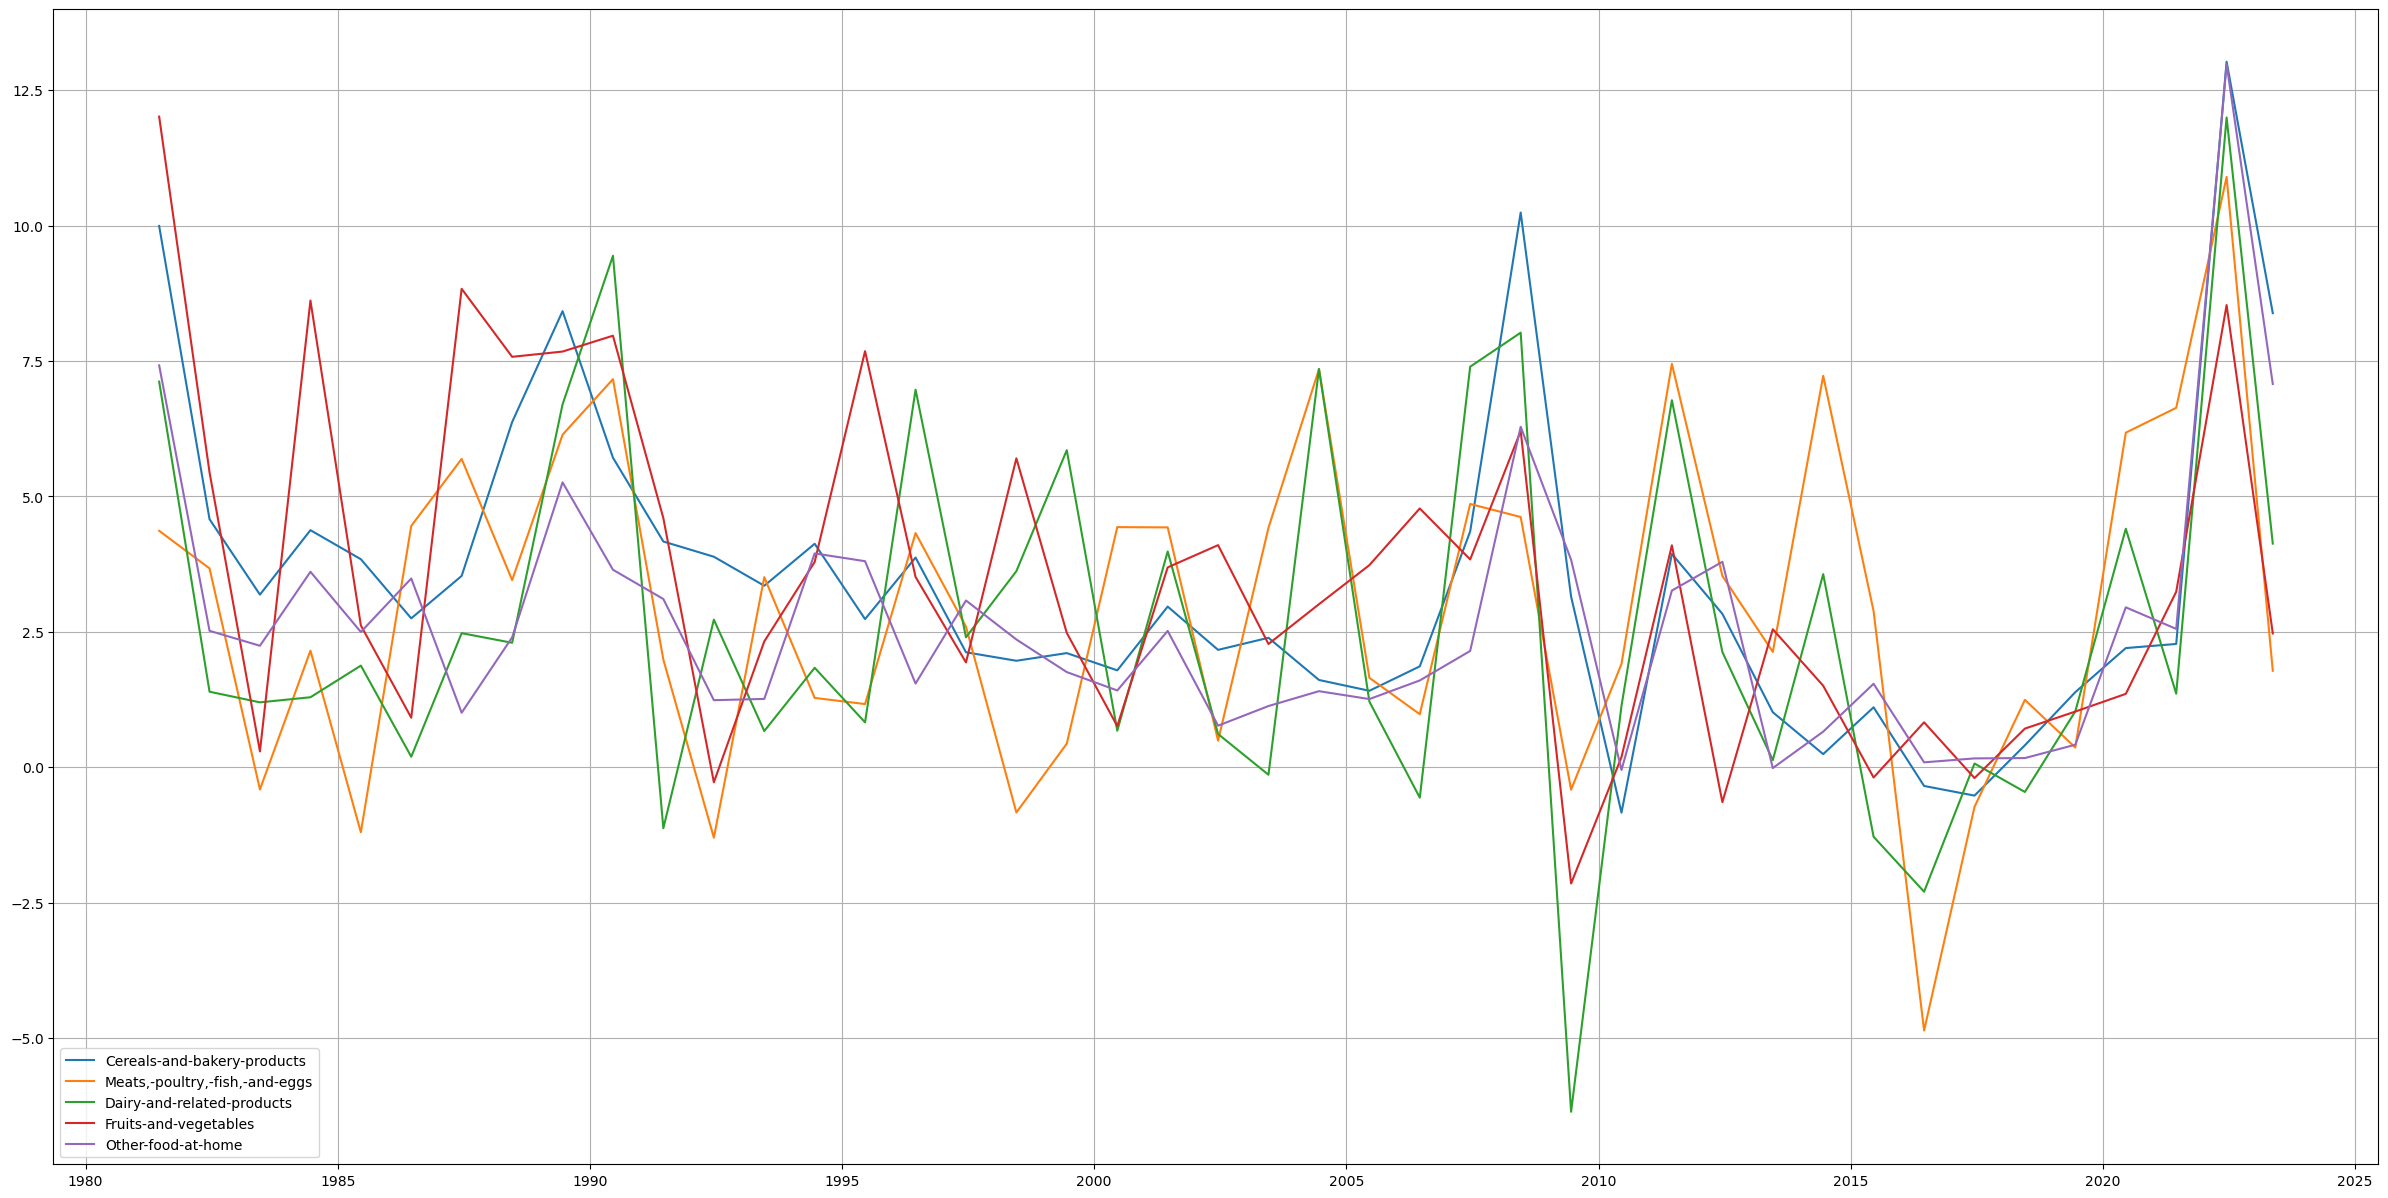

In [ ]:
plt.figure(figsize=(30,15))
yearGrp = test.groupby(test.Date.dt.year).mean()
for cat in catId:
    plt.plot(yearGrp['Date'][1:],(np.diff(yearGrp[cat])/yearGrp[cat][:-1])*100,label = cat)
plt.legend()
plt.grid()
plt.show()